# NYC Bike Rental Analysis

TBD - Introduction paragraph
- Set the context
- Introduce the analysis
- Add an image?


## 1. A story in 9+ million rows

TBD - Introduce the data set
- Where does it come from
- What were some of the challenges - # of rows and optimization
- What are the steps in this section



### Import packages


In [1]:
###TODO - Clean up to what is actually needed

# Import packages
import glob
import numpy as np
import pandas as pd
import math
# import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('seaborn-poster') #sets the size of the charts
# plt.style.use('ggplot')

import seaborn as sns
sns.set(style='ticks', color_codes=True, font_scale=1.25)

# Set display option for floats in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)


### Create helper function


In [2]:
# Function for reading in and processing data files
def read_and_process_simple(filepath, col_types, drop_cols, col_names):
    '''Reads in and processes CitiBike monthly csv data files
         
    Args:
      filepath (string): path to csv data file
    
    Returns:
      temp_df (dataframe): dataframe containing the list of rentals for a given month
    '''
    
    # Read in the data
    temp_df = pd.read_csv(filepath) 
    
    # Drop rows with null values
    temp_df = temp_df.dropna()
    
    # Convert start/stop time columns to datetime
    temp_df.starttime = pd.to_datetime(temp_df.starttime, infer_datetime_format=True)
    
    # Convert column dtypes
    temp_df = temp_df.astype(col_types)
    
    # Drop unnecessary columns
    temp_df = temp_df.drop(drop_cols, axis=1)
    
    # Rename remaining columns
    temp_df.columns = col_names

    return temp_df


### Prep for data import


In [3]:
# Dictionary of columns and optimal dtypes
col_types = {'usertype': 'category', 'birth year': 'int', 'gender': 'int8'}

# Create list of updated column names
col_names = ['tripduration', 'starttime', 'usertype', 'birth_year', 'gender']

# Create list of columns to drop
drop_cols = ['stoptime', 'bikeid', 'start station id', 'end station id', 'start station name',
             'start station latitude', 'start station longitude', 'end station name',
             'end station latitude', 'end station longitude']


### Read in the data


In [4]:
### TODO - Wrap in function

# Read in and process the data
data_files = glob.glob('../data/' + "*.csv")
rentals_dfs = []
for file in data_files:
    rentals_df = read_and_process_simple(file, col_types, drop_cols, col_names)
    rentals_dfs.append(rentals_df)

# Concatentate the list of temp dfs
df = pd.concat(rentals_dfs, ignore_index=True)

# Calculate memory usage
mem_usage = df.memory_usage().sum() / 1024**2

# Print output
print("Dataframe rows, columns: " + str(df.shape))
print('Memory usage after optimization:  {:.2f} MB'.format(mem_usage))

Dataframe rows, columns: (9143693, 5)
Memory usage after optimization:  226.72 MB



## 2. How does a global pandemic affect bike rentals?

TBD - Intro the section

- Add more date dimensions
- Add a count column
- Trip count by dow, hod (gender?, age? usertype?)

### Create new columns for rental count and day/month/year

In [5]:
# Sort the dfs by starttime
df = df.sort_values(by=['starttime']).reset_index(drop=True)

# Create a column to facilitate totaling rental count
df['rental_count'] = 1

# Create new columns for day, month and year
df['hour'] = df.starttime.dt.hour
df['day'] = df.starttime.dt.day
df['month'] = df.starttime.dt.month
df["year"] = df.starttime.dt.year

# Drop starttime column
df = df.drop('starttime', axis=1)


### Pivot by total rentals per month, by year


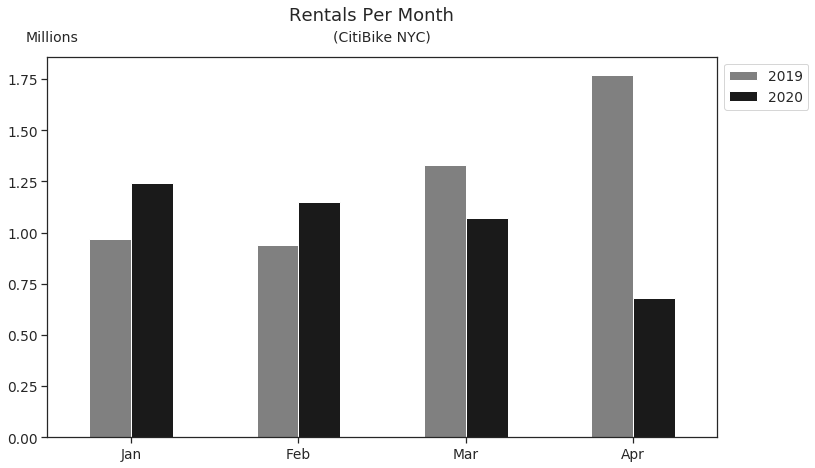

In [6]:
# Pivot rental counts by year and month
df_pivot = df.pivot_table(index='month', columns='year', values='rental_count', aggfunc=np.sum)

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round((x / 1000000),2), axis=1)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}, inplace=True)

# Plot the data and set style
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, color=['gray', 'k'])
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Rentals Per Month", fontsize=18)
plt.title("(CitiBike NYC)", fontsize=14, pad=16)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));

### Pivot by cumulative sum of rentals per year

In [99]:
# Pivot rental count running total by year and month
df_pivot = df.pivot_table(index=['month', 'day'], columns='year', values='rental_count',
                          aggfunc=np.sum).fillna(df_pivot[2019].mean())

# Impute values for 2019-02-29 to account for leap year in 2020 
# df_pivot = df_pivot.fillna(df_pivot[2019].mean())

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round((x / 1000000),2), axis=1)

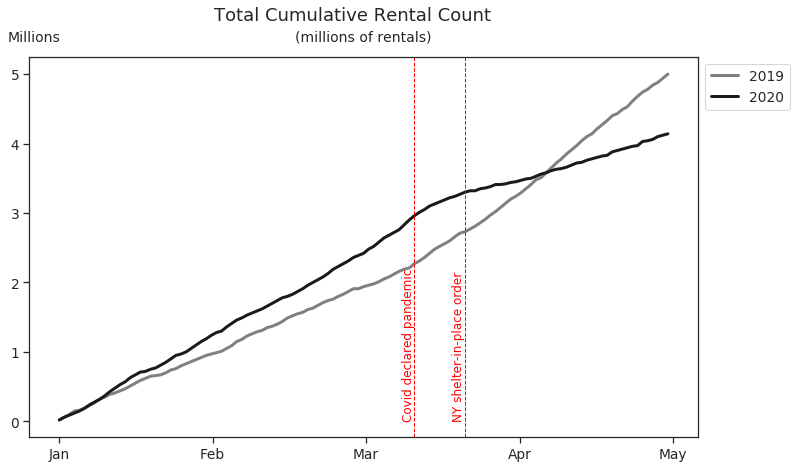

In [100]:
# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['gray', 'k'])

# Plot vertical lines for key dates
plt.axvline(x=70, color='red', linestyle='--', linewidth=1)
plt.text(67.5,0.05,'Covid declared pandemic',rotation=90, fontsize=12, color='red')
plt.axvline(x=80, color='red', linestyle='--', linewidth=1)
plt.text(77.5,0.05,'NY shelter-in-place order',rotation=90, fontsize=12, color='red')

# Add labels and legend
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Count", fontsize=18)
plt.title("(millions of rentals)", fontsize=14, pad=16)
plt.xticks(np.linspace(0, 121, num=5), ['Jan', 'Feb', 'Mar', 'Apr', 'May'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


## 3. What's the affect on rental durations?


In [101]:
# Pivot rental count running total by year and month
df_pivot = df.pivot_table(index=['month', 'day'], columns='year', values='tripduration', aggfunc=np.sum).fillna(df_pivot[2019].mean())

# Impute values for 2019-02-29 to account for leap year in 2020 
# df_pivot = df_pivot.fillna(df_pivot[2019].mean())

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round(((x / 60) / 1000000),2), axis=1)

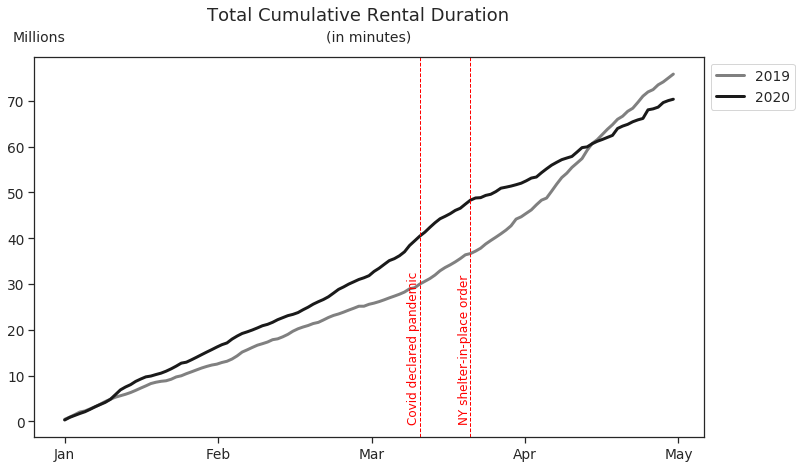

In [102]:
# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['gray', 'k'])

# Plot vertical lines for key dates
plt.axvline(x=70, color='red', linestyle='--', linewidth=1)
plt.text(67.5,0.05,'Covid declared pandemic',rotation=90, fontsize=12, color='red')
plt.axvline(x=80, color='red', linestyle='--', linewidth=1)
plt.text(77.5,0.05,'NY shelter-in-place order',rotation=90, fontsize=12, color='red')

# Add labels and legend
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Duration", fontsize=18)
plt.title("(in minutes)", fontsize=14, pad=16)
plt.xticks(np.linspace(0, 121, num=5), ['Jan', 'Feb', 'Mar', 'Apr', 'May'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


## 4. Do age or gender make a difference?

TBD intro
- Review rental counts

In [103]:
# Pivot rental count running total month, gender
df_pivot = df.pivot_table(index=['month', 'gender'], columns='year', values='rental_count', aggfunc=np.sum)

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round((x / 1000000),2), axis=1)

# Reset the index
df_pivot = df_pivot.reset_index()

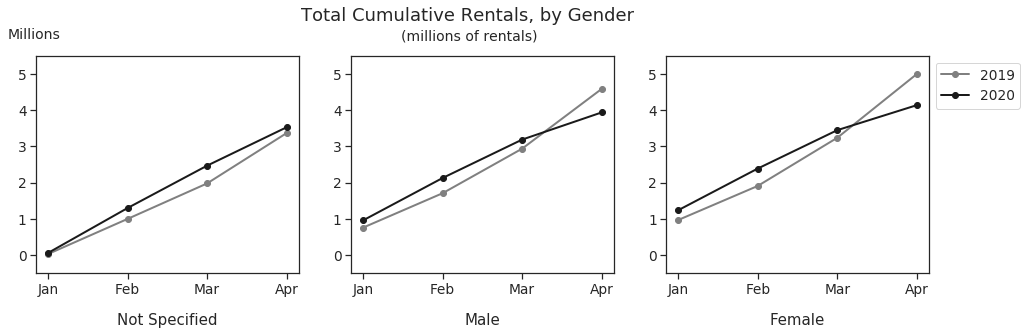

In [104]:
# Set x labels
x_labels = ['Not Specified', 'Male', 'Female']

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
# fig.subplots_adjust(wspace=0.3)

# Create a subplot for each gender
for i in range(3):
    df_temp = df_pivot[df_pivot['gender'] == i]
    df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)
    
    # Extract x and y values 
    x = df_temp_pivot.index.to_list()
    y1 = df_temp_pivot.iloc[:,0].to_list()
    y2 = df_temp_pivot.iloc[:,1].to_list()
    y = [y1, y2]
    labels = ['2019', '2020']
    colors = ['gray', 'k']

    # Plot the values
    plt.subplot(1,3, (i+1))
    for y_arr, label, color in zip(y, labels, colors):
        plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
    plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
    plt.xlabel(x_labels[i], labelpad=16)
#     if i !=0:
#         plt.yticks(np.linspace(-0, 5, 5), " ")
    plt.ylim(-.5,5.5)
    
# Add legend and show the plot
plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rentals, by Gender", y=1.05, fontsize=18)
plt.title("(millions of rentals)", fontsize=14, pad=16, y=1.0, x=-.75)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

In [105]:
# Pivot rental count running total month, gender
df_pivot = df.pivot_table(index=['month', 'gender'], columns='year', values='tripduration', aggfunc=np.sum)

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round(((x / 60) / 1000000),2), axis=1)

# Reset the index
df_pivot = df_pivot.reset_index()

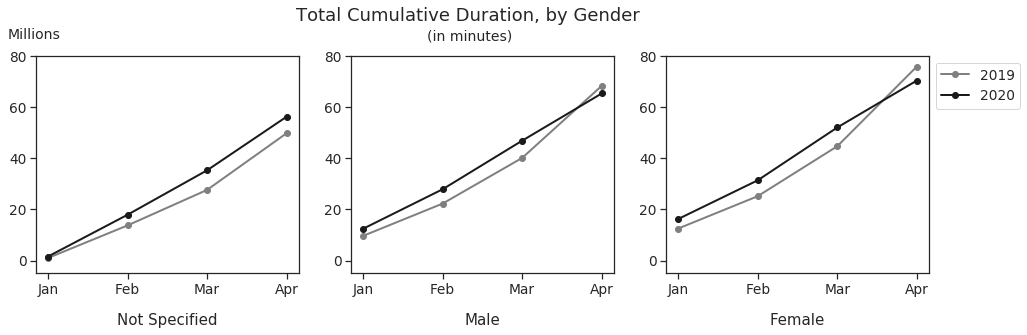

In [106]:
# Set x labels
x_labels = ['Not Specified', 'Male', 'Female']

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
# fig.subplots_adjust(wspace=0.3)

# Create a subplot for each gender
for i in range(3):
    df_temp = df_pivot[df_pivot['gender'] == i]
    df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)
    
    # Extract x and y values 
    x = df_temp_pivot.index.to_list()
    y1 = df_temp_pivot.iloc[:,0].to_list()
    y2 = df_temp_pivot.iloc[:,1].to_list()
    y = [y1, y2]
    labels = ['2019', '2020']
    colors = ['gray', 'k']

    # Plot the values
    plt.subplot(1,3, (i+1))
    for y_arr, label, color in zip(y, labels, colors):
        plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
    plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
    plt.xlabel(x_labels[i], labelpad=16)
#     if i !=0:
#         plt.yticks(np.linspace(-0, 5, 5), " ")
    plt.ylim(-5, 80)
    
# Add legend and show the plot
plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Duration, by Gender", y=1.05, fontsize=18)
plt.title("(in minutes)", fontsize=14, pad=16, y=1.0, x=-.75)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

In [107]:
# Create function to return decade for a given year
def assign_age_cat(year):
    """Returns 1 digit age category when passed 4 digit year
    
    Args:
        year (int): 4 digit year (e.g. 2020)
        
    Returns:
        age category for year as integer
    
    """
    if (year > 1985) and (year <= 2005):
        age_cat = 0
    elif (year >= 1970) and (year <= 1985):
        age_cat = 1
    elif (year >= 1920) and (year < 1970):
        age_cat = 2
    else:
        age_cat = 3
    return age_cat

In [108]:
# Create new column for decade and populate with function
df["age_cat"] = df['birth_year'].apply(assign_age_cat)

# Drop rows with no birth year
df = df[df.age_cat != 3]

In [109]:
# Pivot rental count running total month, gender
df_pivot = df.pivot_table(index=['month', 'age_cat'], columns='year', values='rental_count', aggfunc=np.sum)

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round((x / 1000000),2), axis=1)

# Reset the index
df_pivot = df_pivot.reset_index()

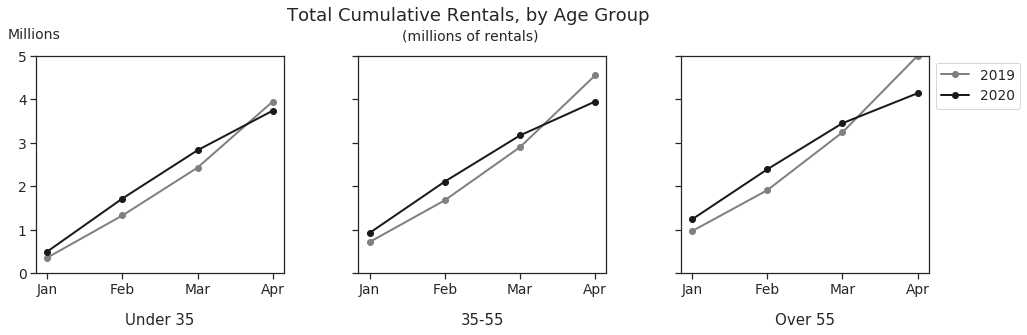

In [110]:
# Set x labels
x_labels = ['Under 35', '35-55', 'Over 55']

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each gender
for i in range(3):
    df_temp = df_pivot[df_pivot['age_cat'] == i]
    df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)
    
    # Extract x and y values 
    x = df_temp_pivot.index.to_list()
    y1 = df_temp_pivot.iloc[:,0].to_list()
    y2 = df_temp_pivot.iloc[:,1].to_list()
    y = [y1, y2]
    labels = ['2019', '2020']
    colors = ['gray', 'k']

    # Plot the values
    plt.subplot(1, 3, (i+1))
    for y_arr, label, color in zip(y, labels, colors):
        plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
    plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
    plt.xlabel(x_labels[i], labelpad=16)
    if i !=0:
        plt.yticks(np.linspace(0, 5, 6), " ")
    plt.ylim(0,5)
    
# Add legend and show the plot
plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rentals, by Age Group", y=1.05, fontsize=18)
plt.title("(millions of rentals)", fontsize=14, pad=16, y=1.0, x=-.85)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

In [111]:
# Pivot rental count running total month, gender
df_pivot = df.pivot_table(index=['month', 'age_cat'], columns='year', values='tripduration', aggfunc=np.sum)

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round(((x / 60) / 1000000),2), axis=1)

# Reset the index
df_pivot = df_pivot.reset_index()

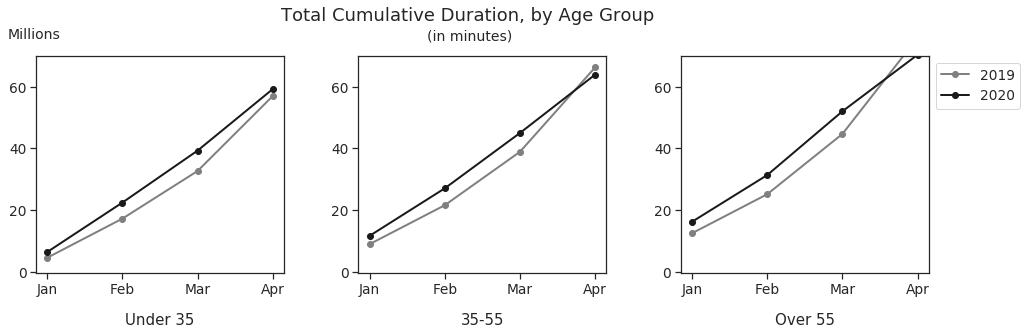

In [112]:
# Set x labels
x_labels = ['Under 35', '35-55', 'Over 55']

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each category
for i in range(3):
    df_temp = df_pivot[df_pivot['age_cat'] == i]
    df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)
    
    # Extract x and y values 
    x = df_temp_pivot.index.to_list()
    y1 = df_temp_pivot.iloc[:,0].to_list()
    y2 = df_temp_pivot.iloc[:,1].to_list()
    y = [y1, y2]
    labels = ['2019', '2020']
    colors = ['gray', 'k']

    # Plot the values
    plt.subplot(1, 3, (i+1))
    for y_arr, label, color in zip(y, labels, colors):
        plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
    plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
    plt.xlabel(x_labels[i], labelpad=16)
#     if i !=0:
#         plt.yticks(np.linspace(0, 5, 6), " ")
    plt.ylim(-.5, 70)
    
# Add legend and show the plot
plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Duration, by Age Group", y=1.05, fontsize=18)
plt.title("(in minutes)", fontsize=14, pad=16, y=1.0, x=-.85)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
plt.show()


## 4. How has customer behavior changed?

TBD intro

### Rental count by user type

In [143]:
# Pivot rental count running total month, user type
df_pivot = df.pivot_table(index=['month', 'usertype'], columns='year', values='rental_count', aggfunc=np.sum)

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round((x / 1000000),2), axis=1)

# Reset the index
df_pivot = df_pivot.reset_index()

In [144]:
# Replace usertype values with 0 and 1
dict = {'Customer': 0, 'Subscriber': 1}
df_pivot = df_pivot.replace({"usertype": dict}) 

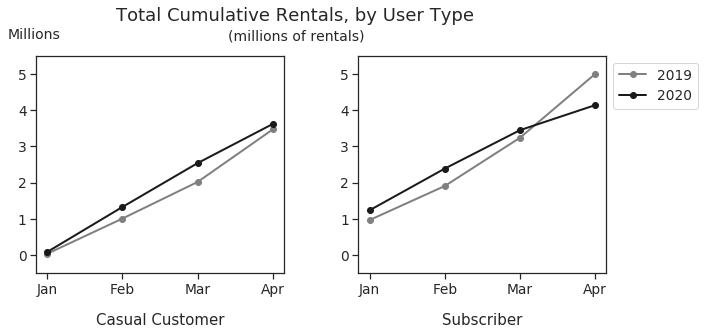

In [145]:
# Set x labels
x_labels = ['Casual Customer', 'Subscriber']

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each category
for i in range(2):
    df_temp = df_pivot[df_pivot['usertype'] == i]
    df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)
    
    # Extract x and y values 
    x = df_temp_pivot.index.to_list()
    y1 = df_temp_pivot.iloc[:,0].to_list()
    y2 = df_temp_pivot.iloc[:,1].to_list()
    y = [y1, y2]
    labels = ['2019', '2020']
    colors = ['gray', 'k']

    # Plot the values
    plt.subplot(1, 3, (i+1))
    for y_arr, label, color in zip(y, labels, colors):
        plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
    plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
    plt.xlabel(x_labels[i], labelpad=16)
#     if i !=0:
#         plt.yticks(np.linspace(0, 5, 6), " ")
    plt.ylim(-.5, 5.5)
    
# Add legend and show the plot
plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rentals, by User Type", y=1.05, x=.35, fontsize=18)
plt.title("(millions of rentals)", fontsize=14, pad=16, y=1.0, x=-.25)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

### Total rental duration by user type

In [146]:
# Pivot rental count running total month, user type
df_pivot = df.pivot_table(index=['month', 'usertype'], columns='year', values='tripduration', aggfunc=np.sum)

# Convert to running total
df_pivot = df_pivot.cumsum()

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round(((x / 60) / 1000000),2), axis=1)

# Reset the index
df_pivot = df_pivot.reset_index()

In [147]:
# Replace usertype values with 0 and 1
dict = {'Customer': 0, 'Subscriber': 1}
df_pivot = df_pivot.replace({"usertype": dict}) 

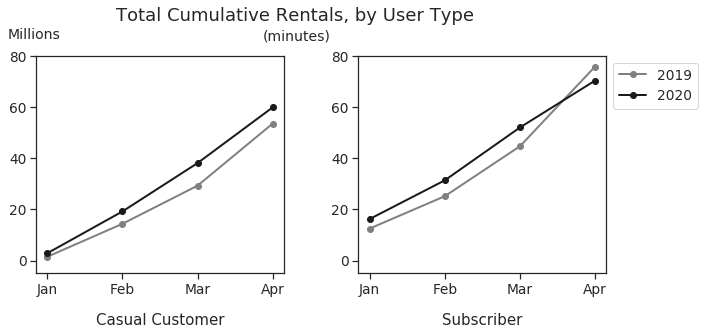

In [148]:
# Set x labels
x_labels = ['Casual Customer', 'Subscriber']

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each category
for i in range(2):
    df_temp = df_pivot[df_pivot['usertype'] == i]
    df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)
    
    # Extract x and y values 
    x = df_temp_pivot.index.to_list()
    y1 = df_temp_pivot.iloc[:,0].to_list()
    y2 = df_temp_pivot.iloc[:,1].to_list()
    y = [y1, y2]
    labels = ['2019', '2020']
    colors = ['gray', 'k']

    # Plot the values
    plt.subplot(1, 3, (i+1))
    for y_arr, label, color in zip(y, labels, colors):
        plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
    plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
    plt.xlabel(x_labels[i], labelpad=16)
#     if i !=0:
#         plt.yticks(np.linspace(0, 5, 6), " ")
    plt.ylim(-5, 80)
    
# Add legend and show the plot
plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rentals, by User Type", y=1.05, x=.35, fontsize=18)
plt.title("(minutes)", fontsize=14, pad=16, y=1.0, x=-.25)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
plt.show()

### Rentals by time of day

In [219]:
# Pivot rental count by hour, month, year
df_pivot = df.pivot_table(index=['hour'], columns=['year','month'], values='rental_count', aggfunc=np.sum)

# Scale rental counts
df_pivot = df_pivot.apply(lambda x: round((x / 1000),2), axis=1)

# Reset the index
# df_pivot = df_pivot.reset_index()

In [234]:
x = df_pivot.index.to_list()
y = df_pivot[year, i+1]

plt.bar

hour
0     6.67
1     3.91
2     2.34
3     1.58
4     2.17
5     8.06
6    24.85
7    51.66
8    90.27
9    67.93
10   43.60
11   43.63
12   51.38
13   54.57
14   56.20
15   57.83
16   67.11
17   93.74
18   86.13
19   57.32
20   38.37
21   26.50
22   19.08
23   11.52
Name: (2019, 1), dtype: float64

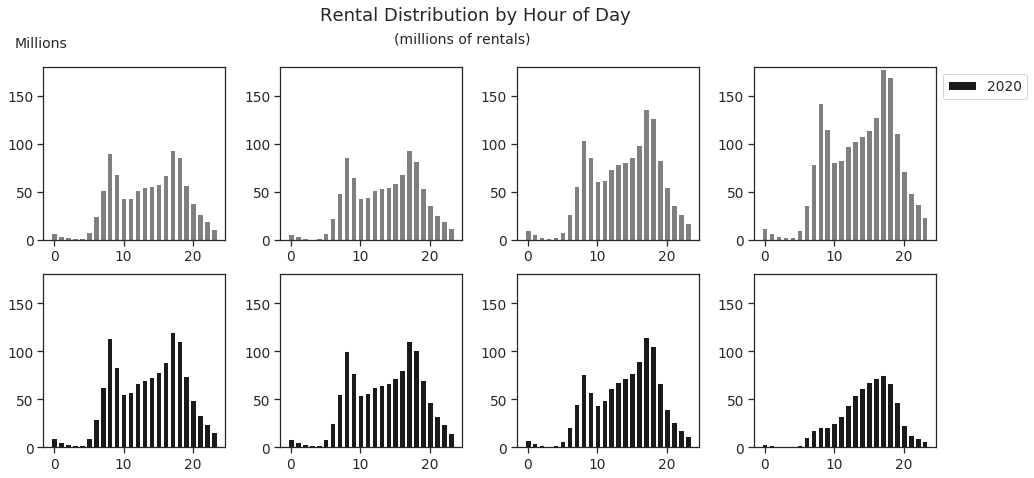

In [308]:
# Set x labels
x_labels = ['Jan', 'Feb', 'Mar', 'Apr']
x = df_pivot.index.to_list()

# Set colors
colors = {2019:'gray', 2020: 'k'}
labels = {2019:'2019', 2020: '2020'}
# Create figure and pad the subplots
fig = plt.figure(figsize=(16,7))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each category
for year in range(2019, 2021, 1):
    for i in range(4):
        # Extract y values 
        y = df_pivot[year, i+1]
        
        # Plot the values
        if year == 2020:
            i=i+4
        plt.subplot(2, 4, (i+1))
        plt.bar(x, y, label=labels[year], color=colors[year])
#         plt.xticks(np.linspace(1, 4, 4), ['12AM', '6AM', '12PM', '6PM'])
#         plt.xlabel(x_labels[i], labelpad=16)
#         if i !=0:
#             plt.yticks(np.linspace(0, 120, 6), " ")
        plt.ylim(0, 180)
    
# Add legend and show the plot
plt.text(0.1, .92, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Rental Distribution by Hour of Day", y=1, x=.5, fontsize=18)
plt.title("(millions of rentals)", fontsize=14, pad=16, y=2.25, x=-1.6)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 2.2));
plt.show()

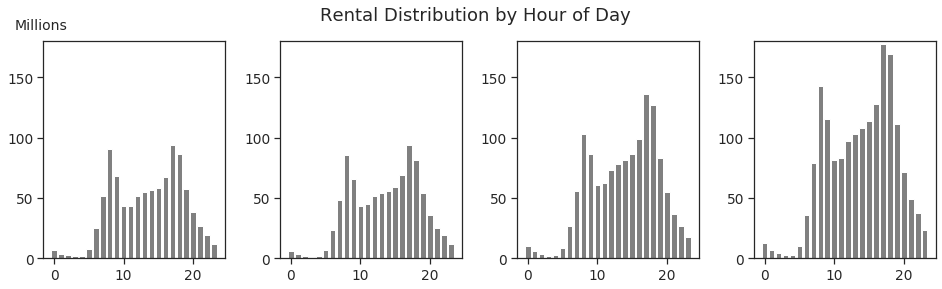

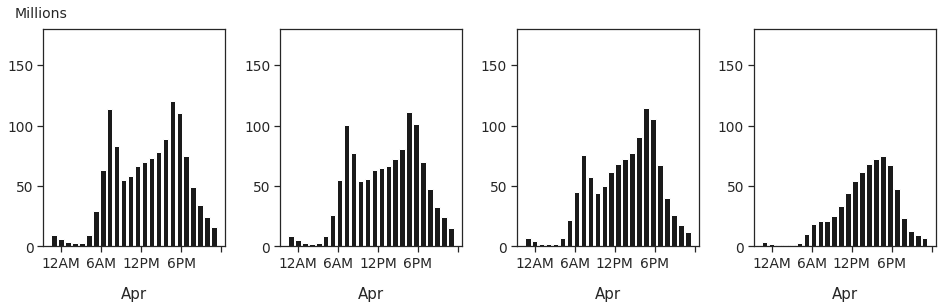

In [321]:
# Set x labels
x_labels = ['Jan', 'Feb', 'Mar', 'Apr']
x = df_pivot.index.to_list()

# Create figure and pad the subplots
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each category
for i in range(4):
    # Extract y values 
    y = df_pivot[2019, i+1]
      
    # Plot the values
    plt.subplot(1, 4, (i+1))
    plt.bar(x, y, label='2019', color='gray')
#         plt.xticks(np.linspace(1, 4, 4), ['12AM', '6AM', '12PM', '6PM'])
#         plt.xlabel(x_labels[i], labelpad=16)
#         if i !=0:
#             plt.yticks(np.linspace(0, 120, 6), " ")
    plt.ylim(0, 180)

# Add legend and show the plot
plt.text(0.1, .92, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Rental Distribution by Hour of Day", y=1, x=.5, fontsize=18)
# plt.title("(millions of rentals)", fontsize=14, pad=16, y=2.25, x=-1.6)
# plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 2.2));
plt.show()
    
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

# Create a subplot for each category
for n in range(4):
    # Extract y values 
    y = df_pivot[2020, n+1]
    plt.subplot(1, 4, (n+1))
    plt.bar(x, y, label='2020', color='k')
    plt.xticks(np.linspace(1, 24, 5), ['12AM', '6AM', '12PM', '6PM'])
    plt.xlabel(x_labels[i], labelpad=16)
#         if i !=0:
#             plt.yticks(np.linspace(0, 120, 6), " ")
    plt.ylim(0, 180)    

# Add legend and show the plot
plt.text(0.1, .92, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
# plt.suptitle("Rental Distribution by Hour of Day", y=1, x=.5, fontsize=18)
# plt.title("(millions of rentals)", fontsize=14, pad=16, y=2.25, x=-1.6)
# plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 2.2));
plt.show()

In [ ]:
del df_temp_pivot
del df_pivot
del df


## 5. Which areas are most impacted?


In [ ]:
import fiona
import geopandas as gpd

from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.plotting import figure, show, save
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper,GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import Reds6 as palette
from bokeh.resources import CDN
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
from mpl_toolkits.basemap import Basemap   
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from descartes import PolygonPatch

# Setup Bokeh to output directly to the notebook
output_notebook(resources=None, verbose=False, hide_banner=True, load_timeout=5000, notebook_type='jupyter')

In [ ]:
#Turn the GeoJson file into a data frame and merge it with df 
data = '../data/nyc_zips.geojson'
gdf = gpd.read_file(data)
# merge = gdf.merge(df, how='left', on='postalCode')
gdf


## 6. What's the bottom line?
